Using device: cuda (Tesla T4)
[matmul] dtype=fp32  M= 256 N= 256 K= 256  time=0.0024s  TFLOPS=0.014
[matmul] dtype=fp32  M= 256 N= 256 K= 512  time=0.0022s  TFLOPS=0.031
[matmul] dtype=fp32  M= 256 N= 256 K=1024  time=0.0023s  TFLOPS=0.058
[matmul] dtype=fp32  M= 256 N= 256 K=2048  time=0.0038s  TFLOPS=0.070
[matmul] dtype=fp32  M= 256 N= 512 K= 256  time=0.0024s  TFLOPS=0.027
[matmul] dtype=fp32  M= 256 N= 512 K= 512  time=0.0025s  TFLOPS=0.055
[matmul] dtype=fp32  M= 256 N= 512 K=1024  time=0.0044s  TFLOPS=0.061
[matmul] dtype=fp32  M= 256 N= 512 K=2048  time=0.0069s  TFLOPS=0.078
[matmul] dtype=fp32  M= 256 N=1024 K= 256  time=0.0023s  TFLOPS=0.059
[matmul] dtype=fp32  M= 256 N=1024 K= 512  time=0.0040s  TFLOPS=0.066
[matmul] dtype=fp32  M= 256 N=1024 K=1024  time=0.0069s  TFLOPS=0.078
[matmul] dtype=fp32  M= 256 N=1024 K=2048  time=0.0124s  TFLOPS=0.086
[matmul] dtype=fp32  M= 256 N=2048 K= 256  time=0.0042s  TFLOPS=0.064
[matmul] dtype=fp32  M= 256 N=2048 K= 512  time=0.0078s  TFL

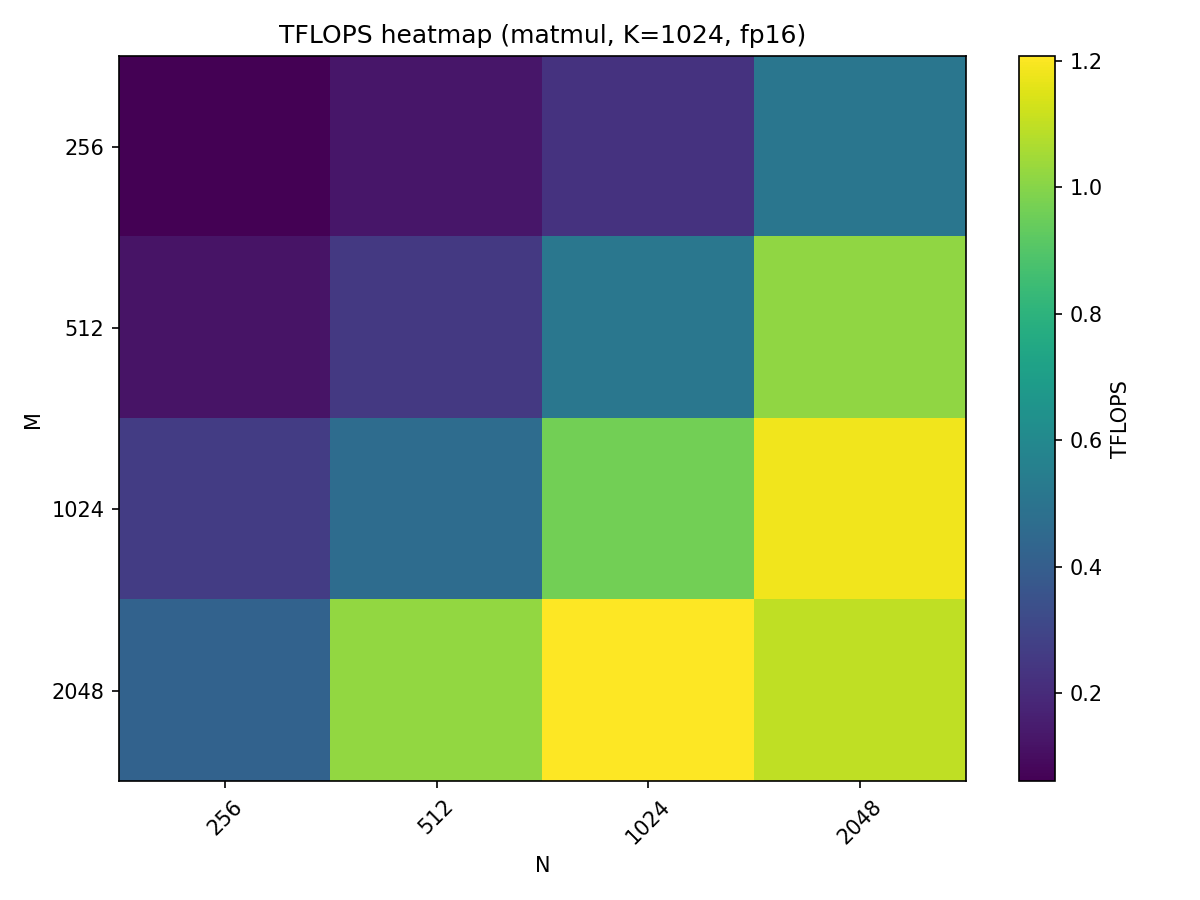

📈 Saved curves to curves_fp32_vs_fp16.png


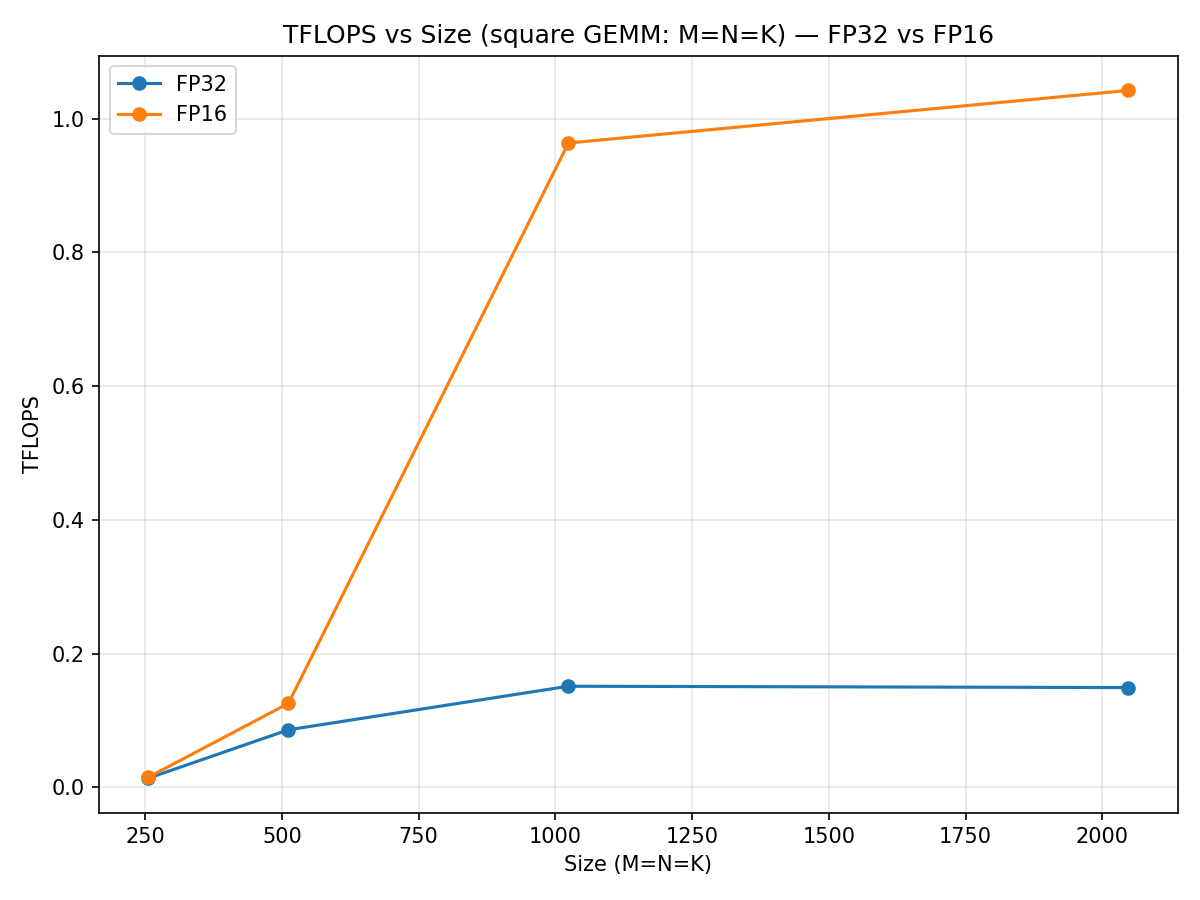


🔮 Simple TFLOPS predictor (RandomForest): R^2=0.979, MAE=0.0356
Predict M=N=K=1024, dtype=fp32 -> TFLOPS≈0.151
Predict M=N=K=1024, dtype=fp16 -> TFLOPS≈0.969
Predict M=N=K=2048, dtype=fp32 -> TFLOPS≈0.150
Predict M=N=K=2048, dtype=fp16 -> TFLOPS≈1.116

First rows of results.csv:


,timestamp,device,device_name,op,dtype,compiled,tf32,M,N,K,iters,elapsed_s,tflops
0,2025-11-10T04:15:20.875866+00:00,cuda,Tesla T4,matmul,fp32,1,1,256,256,256,30,0.002600,0.012908
1,2025-11-10T04:15:21.247170+00:00,cuda,Tesla T4,matmul,fp32,1,1,256,256,512,30,0.003666,0.018305
2,2025-11-10T04:15:21.252780+00:00,cuda,Tesla T4,matmul,fp32,1,1,256,256,1024,30,0.002574,0.052137
3,2025-11-10T04:15:21.259912+00:00,cuda,Tesla T4,matmul,fp32,1,1,256,256,2048,30,0.003831,0.070062
4,2025-11-10T04:15:21.443568+00:00,cuda,Tesla T4,matmul,fp32,1,1,256,512,256,30,0.002782,0.024123


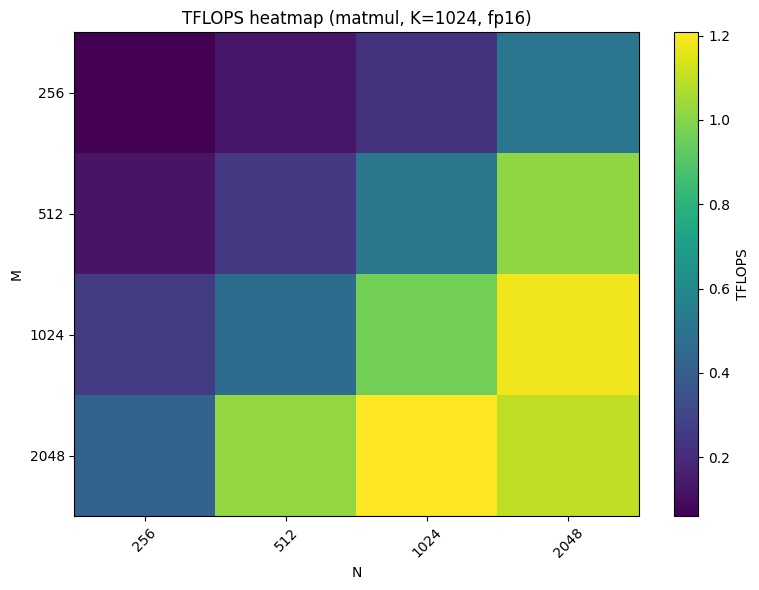

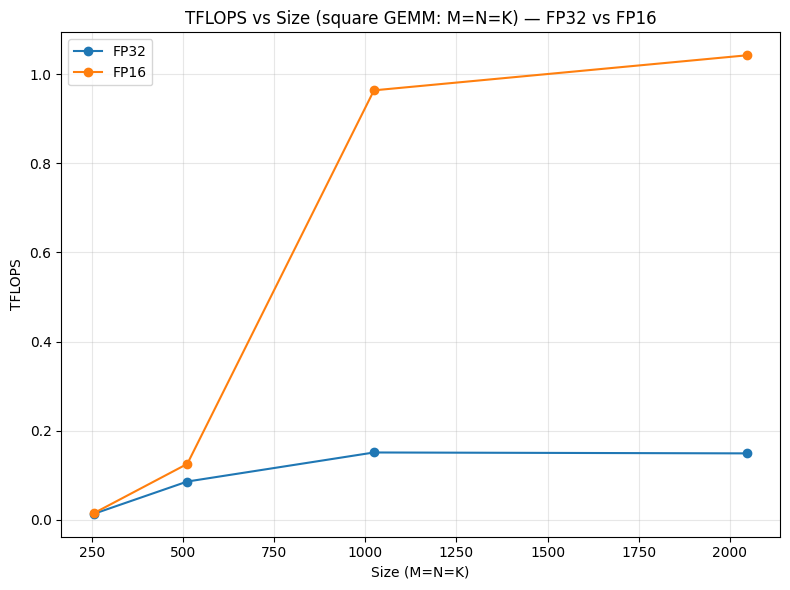

In [ ]:
# === Version-2 Code (Extended) ==========================
# 1) Installs deps
# 2) Defines a PyTorch GEMM micro-benchmark (matmul only)
# 3) Runs a sweep over M,N,K with FP32 vs FP16, logs to results.csv
# 4) Renders a TFLOPS heatmap (K fixed)
# 5) Plots TFLOPS vs size curves (square sizes) comparing FP32 vs FP16
# 6) Trains a simple RandomForest predictor for TFLOPS from (M,N,K,dtype)
# -----------------------------------------------------------------------------


# -----------------------------
# 0) INSTALL DEPENDENCIES
# -----------------------------
import sys, subprocess, os
def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

pip_install(["torch", "pandas", "numpy", "matplotlib", "scikit-learn"])

# -----------------------------
# 1) IMPORTS
# -----------------------------
import time, csv, itertools
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# -----------------------------
# 2) USER CONFIG (as requested)
# -----------------------------
# Change sizes at the top:
SIZES         = [256, 512, 1024, 2048]  # M and N grid
K_VALUES      = [256, 512, 1024, 2048]  # K sweep
# Focus on one op:
OPS           = ["matmul"]
# Try FP32 vs FP16 to see precision trade-offs:
DTYPES        = ["fp32", "fp16"]

DEVICE_MODE   = "auto"                  # "auto" | "cuda" | "cpu"
ITERS         = 30
WARMUP        = 5
USE_COMPILE   = True                    # torch.compile best-effort
ALLOW_TF32    = True                    # TF32 for CUDA matmul if supported
OUTFILE       = "results.csv"

# Heatmap rendering config (post-run)
HEATMAP_OP       = "matmul"
HEATMAP_DTYPE    = "fp16"               # "fp32"|"fp16" (must exist in results)
HEATMAP_K        = 1024                 # pick one from K_VALUES
HEATMAP_FILENAME = "heatmap.png"
HEATMAP_TITLE    = "TFLOPS heatmap (matmul, K=1024, fp16)"

# Curve plot config (square sizes: M=N=K)
CURVE_OUT = "curves_fp32_vs_fp16.png"
CURVE_TITLE = "TFLOPS vs Size (square GEMM: M=N=K) — FP32 vs FP16"

# -----------------------------
# 3) HELPERS
# -----------------------------
def dtype_from_str(s):
    s = s.lower()
    if s in ("fp32","float32"): return torch.float32
    if s in ("fp16","float16"): return torch.float16
    raise ValueError(f"Unknown/unsupported dtype here: {s} (use fp32 or fp16)")

def can_use_dtype_on_device(dtype, device):
    if device.type == "cpu":
        # Keep CPU simple: fp32 safe; fp16 is often unsupported/slow on CPU
        return dtype is torch.float32
    if device.type == "cuda":
        # fp16 widely supported on CUDA
        return True
    return False

def make_tensors(M, N, K, dtype, device):
    A = torch.randn(M, K, dtype=dtype, device=device)
    B = torch.randn(K, N, dtype=dtype, device=device)
    return (A, B)

def run_once(compiled=False):
    f = lambda A, B: A @ B
    if compiled:
        try:
            f = torch.compile(f, fullgraph=False)  # best-effort
        except Exception:
            pass
    return f

def time_op(f, tensors, iters, device):
    if device.type == "cuda":
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        starter.record()
        for _ in range(iters):
            _ = f(*tensors)
        ender.record()
        torch.cuda.synchronize()
        ms = starter.elapsed_time(ender)
        return ms / 1000.0
    else:
        t0 = time.perf_counter()
        for _ in range(iters):
            _ = f(*tensors)
        return time.perf_counter() - t0

def flops_gemm(M, N, K):
    # 2*M*N*K FLOPs
    return 2.0 * M * N * K

# -----------------------------
# 4) DEVICE SETUP
# -----------------------------
if DEVICE_MODE == "auto":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device(DEVICE_MODE)

if device.type == "cuda":
    try:
        torch.backends.cuda.matmul.allow_tf32 = bool(ALLOW_TF32)
    except Exception:
        pass

device_name = torch.cuda.get_device_name(0) if device.type == "cuda" else "cpu"
print(f"Using device: {device} ({device_name})")

# -----------------------------
# 5) BENCHMARK SWEEP
# -----------------------------
header = ["timestamp","device","device_name","op","dtype","compiled","tf32",
          "M","N","K","iters","elapsed_s","tflops"]

first_write = not os.path.exists(OUTFILE)
with open(OUTFILE, "a", newline="") as fcsv:
    w = csv.writer(fcsv)
    if first_write:
        w.writerow(header)

    for dtype_str, M, N, K in itertools.product(DTYPES, SIZES, SIZES, K_VALUES):
        op = "matmul"
        try:
            dtype = dtype_from_str(dtype_str)
        except Exception:
            continue
        if not can_use_dtype_on_device(dtype, device):
            continue

        # Create tensors
        try:
            tensors = make_tensors(M, N, K, dtype, device)
        except RuntimeError:
            # OOM or unsupported allocation – skip
            continue

        # Warmup
        f = run_once(compiled=USE_COMPILE)
        for _ in range(WARMUP):
            _ = f(*tensors)
        if device.type == "cuda":
            torch.cuda.synchronize()

        # Timed
        elapsed = time_op(f, tensors, ITERS, device)
        tflops = flops_gemm(M, N, K) / (elapsed * 1e12)

        row = [datetime.now(timezone.utc).isoformat(), device.type, device_name, op, dtype_str,
               int(USE_COMPILE), int(ALLOW_TF32 if device.type=="cuda" else 0),
               M, N, K, ITERS, f"{elapsed:.6f}", f"{tflops:.6f}"]
        w.writerow(row)
        fcsv.flush()
        print(f"[{op:<6}] dtype={dtype_str:<5} M={M:4} N={N:4} K={K:4}  "
              f"time={elapsed:.4f}s  TFLOPS={tflops:.3f}")

print(f"\n✅ Wrote results to {OUTFILE}")

# -----------------------------
# 6) VISUALIZE HEATMAP (fp16, fixed K)
# -----------------------------
df = pd.read_csv(OUTFILE)

def render_heatmap(df, op, dtype_substr, K, out_file, title=None):
    dff = df[(df["op"]==op) & (df["K"]==K)]
    mask = dff["dtype"].str.contains(dtype_substr, case=False, na=False)
    dff = dff[mask]
    if dff.empty:
        print("No data to plot for heatmap. Adjust HEATMAP_* config.")
        return
    pv = dff.pivot_table(index="M", columns="N", values="tflops", aggfunc="mean")
    plt.figure(figsize=(8,6))
    plt.imshow(pv.values, aspect="auto")
    plt.xticks(range(len(pv.columns)), pv.columns, rotation=45)
    plt.yticks(range(len(pv.index)), pv.index)
    plt.xlabel("N")
    plt.ylabel("M")
    plt.title(title or f"TFLOPS heatmap (op={op}, K={K}, dtype~{dtype_substr})")
    plt.colorbar(label="TFLOPS")
    plt.tight_layout()
    plt.savefig(out_file, dpi=150)
    print(f"📈 Saved heatmap to {out_file}")

render_heatmap(df, HEATMAP_OP, HEATMAP_DTYPE, HEATMAP_K, HEATMAP_FILENAME, HEATMAP_TITLE)

# Show heatmap inline
if os.path.exists(HEATMAP_FILENAME):
    from IPython.display import Image, display
    display(Image(filename=HEATMAP_FILENAME))

# -----------------------------
# 7) PLOT CURVES: TFLOPS vs SIZE (square GEMM M=N=K) FP32 vs FP16
# -----------------------------
def plot_curves_square(df, sizes, out_file, title=None):
    # Filter square runs (M=N=K) and op=matmul
    sq = df[(df["op"]=="matmul") & (df["M"]==df["N"]) & (df["N"]==df["K"])]
    if sq.empty:
        print("No square GEMM data to plot curves.")
        return

    # Build series for each dtype
    series = {}
    for dt in ["fp32","fp16"]:
        d = sq[sq["dtype"]==dt]
        # For each size, compute mean TFLOPS across repeats (if any)
        xs, ys = [], []
        for s in sizes:
            sub = d[(d["M"]==s) & (d["N"]==s) & (d["K"]==s)]
            if not sub.empty:
                xs.append(s)
                ys.append(sub["tflops"].mean())
        if xs:
            series[dt] = (xs, ys)

    if not series:
        print("No data for FP32/FP16 curves.")
        return

    plt.figure(figsize=(8,6))
    for dt, (xs, ys) in series.items():
        plt.plot(xs, ys, marker="o", label=dt.upper())
    plt.xlabel("Size (M=N=K)")
    plt.ylabel("TFLOPS")
    plt.title(title or "TFLOPS vs Size (square GEMM)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_file, dpi=150)
    print(f"📈 Saved curves to {out_file}")
    display(Image(filename=out_file))

plot_curves_square(df, sizes=SIZES, out_file=CURVE_OUT, title=CURVE_TITLE)

# -----------------------------
# 8) SIMPLE PERFORMANCE PREDICTOR (RandomForest on TFLOPS)
# -----------------------------
# Use CSV data to train a small model: features = (M,N,K,dtype), target = TFLOPS
work = df[df["op"]=="matmul"].copy()
if not work.empty:
    # Encode dtype as binary feature (fp16=1, fp32=0)
    work["dtype_fp16"] = (work["dtype"].str.lower()=="fp16").astype(int)
    X = work[["M","N","K","dtype_fp16"]].values
    y = work["tflops"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    r2  = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\n🔮 Simple TFLOPS predictor (RandomForest): R^2={r2:.3f}, MAE={mae:.4f}")

    # Show a tiny preview: predict for a couple of sizes
    probe = np.array([[1024,1024,1024,0],  # fp32
                      [1024,1024,1024,1],  # fp16
                      [2048,2048,2048,0],  # fp32
                      [2048,2048,2048,1]]) # fp16
    preds = rf.predict(probe)
    for row, p in zip(probe, preds):
        print(f"Predict M=N=K={row[0]}, dtype={'fp16' if row[3]==1 else 'fp32'} -> TFLOPS≈{p:.3f}")
else:
    print("Not enough data to train predictor.")

# -----------------------------
# 9) SHOW CSV HEAD
# -----------------------------
print("\nFirst rows of results.csv:")
from IPython.display import display, Image
display(df.head())
# =============================================================================
